# Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
torch.manual_seed(42)
np.random.seed(42)
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data load

In [4]:
expression_data = pd.read_csv('../RawData/TCGA-SARC.star_tpm.tsv', sep='\t', index_col=0)  # Gene expression (TPM)
methylation_data = pd.read_csv('../RawData/TCGA-SARC.methylation450.tsv', sep='\t', index_col=0)  # DNA methylation
copy_number_data = pd.read_csv('../RawData/TCGA-SARC.gene-level_absolute.tsv', sep='\t', index_col=0) # Copy number variations

try:
    phenotype_data = pd.read_csv('../RawData/TCGA-SARC.clinical.tsv', sep='\t', index_col=0)
except Exception as e:
    print("Error while loading phenotype_data:", e)
    with open('../RawData/TCGA-SARC.clinical.tsv', 'r') as f:
        for i, line in enumerate(f):
            try:
                pd.read_csv(pd.compat.StringIO(line), sep='\t')
            except Exception as row_e:
                print(f"Error in line {i}: {row_e}")
    phenotype_data = pd.read_csv('../RawData/TCGA-SARC.clinical.tsv', sep='\t', index_col=0, on_bad_lines='skip')

print("Data shapes:")
print(f"Expression data: {expression_data.shape}")
print(f"Methylation data: {methylation_data.shape}")
print(f"Copy number data: {copy_number_data.shape}")
print(f"Phenotype data: {phenotype_data.shape}")

Data shapes:
Expression data: (60660, 265)
Methylation data: (486427, 269)
Copy number data: (60623, 248)
Phenotype data: (272, 78)


# Sample Matching

In [5]:
print("Checking for missing values in phenotype data:")
missing_values = phenotype_data.isnull().sum()
print(missing_values[missing_values > 0])

print()
print("Checking sample overlap between different omics data:")

samples_expression = set(expression_data.columns)
samples_methylation = set(methylation_data.columns)
samples_cnv = set(copy_number_data.columns)
samples_clinical = set(phenotype_data.index)
print("Sample overlap:")
print(f"Expression samples: {len(samples_expression)}")
print(f"Methylation samples: {len(samples_methylation)}")
print(f"CNV samples: {len(samples_cnv)}")
print(f"Clinical samples: {len(samples_clinical)}")

# Find common samples across all omics
common_samples = list(samples_expression.intersection(samples_methylation, samples_cnv, samples_clinical))
print(f"Common samples across all omics: {len(common_samples)}")

# Filter data to keep only common samples
expression_data = expression_data[common_samples]
methylation_data = methylation_data[common_samples]
copy_number_data = copy_number_data[common_samples]
phenotype_data = phenotype_data.loc[common_samples]



Checking for missing values in phenotype data:
days_to_birth.demographic                                      1
year_of_birth.demographic                                      4
days_to_death.demographic                                    170
year_of_death.demographic                                    195
entity_submitter_id.annotations                              254
notes.annotations                                            254
submitter_id.annotations                                     254
classification.annotations                                   254
entity_id.annotations                                        254
created_datetime.annotations                                 254
annotation_id.annotations                                    254
entity_type.annotations                                      254
updated_datetime.annotations                                 254
case_id.annotations                                          254
state.annotations                          

# Data preprocessing

### Check Null value

In [6]:
#Check for null values of expression data
print("Checking for null values in expression data:")
null_expression = expression_data.isnull().sum().sum()
if null_expression > 0:
    print(f"Expression data contains {null_expression} null values.")
else:   
    print("No null values found in expression data.")
print()


# Check for null values in methylation data
print("Checking for null values in methylation data:")
null_methylation = methylation_data.isnull().sum().sum()
if null_methylation > 0:
    print(f"Methylation data contains {null_methylation} null values.")
else:
    print("No null values found in methylation data.")
print()


# Check for null values in copy number data
print("Checking for null values in copy number data:")
null_copy_number = copy_number_data.isnull().sum().sum()
if null_copy_number > 0:
    print(f"Copy number data contains {null_copy_number} null values.")
else:
    print("No null values found in copy number data.")
max_value = copy_number_data.max().max()
min_value = copy_number_data.min().min()

print(f"Maximum CNV value: {max_value}")
print(f"Minimum CNV value: {min_value}")
print()


# Check for null values in phenotype data
print("Checking for null values in phenotype data:")
null_phenotype = phenotype_data.isnull().sum().sum()
if null_phenotype > 0:
    print(f"Phenotype data contains {null_phenotype} null values.")
else:
    print("No null values found in phenotype data.")



Checking for null values in expression data:
No null values found in expression data.

Checking for null values in methylation data:
Methylation data contains 19622910 null values.

Checking for null values in copy number data:
Copy number data contains 994360 null values.
Maximum CNV value: 7.0
Minimum CNV value: 0.0

Checking for null values in phenotype data:
Phenotype data contains 3960 null values.


### Process data

In [7]:
print("Dropping rows with entirely NaN values...")
print("=" * 50)

def drop_all_nan_rows(data, name):
    """Drop rows that are entirely NaN and report the change."""
    before_rows = data.shape[0]
    all_nan_mask = data.isna().all(axis=1)
    all_nan_count = all_nan_mask.sum()
    
    # Drop entirely NaN rows
    data_clean = data.loc[~all_nan_mask]
    after_rows = data_clean.shape[0]
    
    print(f"\n📊 {name}:")
    print(f"   Rows before: {before_rows:,}")
    print(f"   Entirely NaN rows dropped: {all_nan_count:,}")
    print(f"   Rows after: {after_rows:,}")
    
    # Check remaining NaN status
    remaining_nan = data_clean.isna().sum().sum()
    remaining_all_nan_rows = data_clean.isna().all(axis=1).sum()
    print(f"   Remaining NaN values: {remaining_nan:,}")
    print(f"   Remaining entirely NaN rows: {remaining_all_nan_rows}")
    
    if all_nan_count > 0:
        print(f"   ✅ Dropped {all_nan_count} entirely NaN rows")
    else:
        print(f"   ✅ No entirely NaN rows found")
    
    return data_clean

# Drop entirely NaN rows from each omics
expression_data = drop_all_nan_rows(expression_data, "Expression Data")
methylation_data = drop_all_nan_rows(methylation_data, "Methylation Data")
copy_number_data = drop_all_nan_rows(copy_number_data, "Copy Number Data")

print("\n" + "=" * 50)
print("✅ Entirely NaN row removal completed!")

Dropping rows with entirely NaN values...

📊 Expression Data:
   Rows before: 60,660
   Entirely NaN rows dropped: 0
   Rows after: 60,660
   Remaining NaN values: 0
   Remaining entirely NaN rows: 0
   ✅ No entirely NaN rows found

📊 Methylation Data:
   Rows before: 486,427
   Entirely NaN rows dropped: 64,828
   Rows after: 421,599
   Remaining NaN values: 3,675,222
   Remaining entirely NaN rows: 0
   ✅ Dropped 64828 entirely NaN rows

📊 Copy Number Data:
   Rows before: 60,623
   Entirely NaN rows dropped: 3,383
   Rows after: 57,240
   Remaining NaN values: 162,142
   Remaining entirely NaN rows: 0
   ✅ Dropped 3383 entirely NaN rows

✅ Entirely NaN row removal completed!


In [8]:
# expression data preprocessing -------------------------------------------------->

# Log2 transform
expression_data_log = np.log2(expression_data + 1)

# Z-score standardization
selector_expr = VarianceThreshold(threshold=0.01)
expression_filtered = pd.DataFrame(
    selector_expr.fit_transform(expression_data_log.T).T,
    index=expression_data_log.index[selector_expr.get_support()],
    columns=expression_data_log.columns
)
expression_data_scaled = expression_filtered.copy()



# Methylation data preprocessing -------------------------------------------------->

# Drop probes with more than 20% missing values
methylation_data = methylation_data.dropna(thresh=0.8* methylation_data.shape[1], axis=0)

# Convert beta values to M-values
epsilon = 1e-6
methylation_beta = methylation_data.clip(epsilon, 1 - epsilon)
methylation_m_values = np.log2(methylation_beta / (1 - methylation_beta))

# Remove low-variance methylation probes
selector = VarianceThreshold(threshold=0.01)
methylation_filtered = pd.DataFrame(
    selector.fit_transform(methylation_m_values.T).T,
    index=methylation_m_values.index[selector.get_support()],
    columns=methylation_m_values.columns
)
methylation_scaled = methylation_filtered.copy()


# Copy number data preprocessing -------------------------------------------------->

# Drop genes with >20% missing values
copy_number_data_filtered = copy_number_data.loc[
    copy_number_data.isnull().mean(axis=1) < 0.2
]
# # Cap values to biologically plausible range
# copy_number_imputed = copy_number_data_filtered
cnv_clipped = copy_number_data_filtered.clip(lower=0.05, upper=6)
log_cnv = np.log2(cnv_clipped / 2)
cnv_selector = VarianceThreshold(threshold=0.01)
copy_number_scaled = pd.DataFrame(
    cnv_selector.fit_transform(log_cnv.T).T,
    index=log_cnv.index[cnv_selector.get_support()],
    columns=log_cnv.columns
)

In [9]:
# Phenotype data preprocessing -------------------------------------------------->
subtype_column = 'primary_diagnosis.diagnoses'
print(f"Using '{subtype_column}' as the subtype column")
print(f"Subtype distribution:\n{phenotype_data[subtype_column].value_counts()}")
print()
# Only keep selected subtypes
selected_subtypes = [
    'Leiomyosarcoma, NOS',
    'Dedifferentiated liposarcoma',
    'Undifferentiated sarcoma'
 ]
phenotype_data = phenotype_data[phenotype_data[subtype_column].isin(selected_subtypes)]
print(f"Filtered to selected subtypes. Remaining samples: {len(phenotype_data)}")
# Checking missing values in the subtype column
missing_subtypes = phenotype_data[subtype_column].isnull().sum()
print(f"Missing values in subtype column: {missing_subtypes}")
if missing_subtypes > 0:
    phenotype_data_clean = phenotype_data.dropna(subset=[subtype_column])
    print(f"Removed {missing_subtypes} samples with missing subtypes")
    print(f"Remaining samples: {len(phenotype_data_clean)}")
else:
    phenotype_data_clean = phenotype_data.copy()
    print("No missing subtypes found")

Using 'primary_diagnosis.diagnoses' as the subtype column
Subtype distribution:
primary_diagnosis.diagnoses
Leiomyosarcoma, NOS                        96
Dedifferentiated liposarcoma               53
Undifferentiated sarcoma                   34
Fibromyxosarcoma                           22
Malignant fibrous histiocytoma             11
Malignant peripheral nerve sheath tumor    10
Synovial sarcoma, spindle cell              6
Giant cell sarcoma                          3
Myxoid leiomyosarcoma                       2
Pleomorphic liposarcoma                     2
Synovial sarcoma, NOS                       2
Synovial sarcoma, biphasic                  2
Aggressive fibromatosis                     1
Abdominal fibromatosis                      1
Liposarcoma, well differentiated            1
Name: count, dtype: int64

Filtered to selected subtypes. Remaining samples: 183
Missing values in subtype column: 0
No missing subtypes found


### Sample matching

In [10]:
# Extract subtypes for the common samples
subtypes = phenotype_data_clean[subtype_column]
# Encode subtypes as numeric labels
label_encoder = LabelEncoder()
subtype_encoded = label_encoder.fit_transform(subtypes)
# Create mapping to encode subtype classes
subtype_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"\nSubtype encoding mapping:")
for subtype, encoded in subtype_mapping.items():
    print(f"  {encoded}: {subtype}")
# Converted to pandas Series to easily handle the index
subtype_encoded = pd.Series(subtype_encoded, index=subtypes.index, name='subtype_encoded')
print(f"\nEncoded subtype distribution:")
print(subtype_encoded.value_counts().sort_index())
# Update common samples with available subtypes
valid_samples = list(set(common_samples).intersection(set(phenotype_data_clean.index)))
print(f"\nUpdating common samples from {len(common_samples)} to {len(valid_samples)} (removed samples with missing subtypes or not in selected subtypes)")
expression_data_scaled = expression_data_scaled[valid_samples]
methylation_scaled = methylation_scaled[valid_samples]
copy_number_scaled = copy_number_scaled[valid_samples]
subtype_encoded = subtype_encoded.loc[valid_samples]
common_samples = valid_samples
print()
print(f"Final data shapes after phenotype preprocessing:")
print(f"  Expression: {expression_data_scaled.shape}")
print(f"  Methylation: {methylation_scaled.shape}")
print(f"  Copy number: {copy_number_scaled.shape}")
print(f"  Phenotype: {phenotype_data_clean.shape}")
print(f"  Subtypes: {len(subtype_encoded)}")
print(f"  Common samples: {len(common_samples)}")


Subtype encoding mapping:
  0: Dedifferentiated liposarcoma
  1: Leiomyosarcoma, NOS
  2: Undifferentiated sarcoma

Encoded subtype distribution:
subtype_encoded
0    53
1    96
2    34
Name: count, dtype: int64

Updating common samples from 246 to 183 (removed samples with missing subtypes or not in selected subtypes)

Final data shapes after phenotype preprocessing:
  Expression: (44663, 183)
  Methylation: (396650, 183)
  Copy number: (56756, 183)
  Phenotype: (183, 78)
  Subtypes: 183
  Common samples: 183


In [11]:
# import numpy as np
# import pandas as pd

# # Summary statistics for preprocessed datasets (expression, methylation, copy number)
# # Uses variables already defined in the notebook:
# #   expression_data_scaled, methylation_scaled, copy_number_scaled


# datasets = {
#     "Expression": expression_data_scaled,
#     "Methylation": methylation_scaled,
#     "CopyNumber": copy_number_scaled
# }

# def brief_stats(df: pd.DataFrame, name: str, top_n: int = 5):
#     print(f"\n=== {name} ===")
#     print(f"Shape: features={df.shape[0]} x samples={df.shape[1]}")
#     arr = df.values.flatten()
#     arr = arr[~np.isnan(arr)]
#     print(f"Overall mean:   {np.mean(arr):.6f}")
#     print(f"Overall median: {np.median(arr):.6f}")
#     print(f"Overall max:    {np.max(arr):.6f}")
#     print(f"Overall min:    {np.min(arr):.6f}")
#     # Per-feature (row) summaries
#     feat_mean = df.mean(axis=1)
#     feat_median = df.median(axis=1)
#     feat_max = df.max(axis=1)
#     feat_min = df.min(axis=1)
#     # Per-sample (column) summaries
#     samp_mean = df.mean(axis=0)
#     samp_median = df.median(axis=0)
#     samp_max = df.max(axis=0)
#     samp_min = df.min(axis=0)
#     top_sample = samp_mean.idxmax()
#     bottom_sample = samp_mean.idxmin()
#     print(f"\nSample with highest mean: {top_sample} (mean={samp_mean.max():.6f})")
#     print(f"Sample with lowest mean:  {bottom_sample} (mean={samp_mean.min():.6f})")
#     # Optional concise summary DataFrame
#     summary_df = pd.DataFrame({
#         "feature_mean_mean": [feat_mean.mean()],
#         "feature_mean_median": [feat_mean.median()],
#         "feature_mean_max": [feat_mean.max()],
#         "feature_mean_min": [feat_mean.min()],
#         "sample_mean_mean": [samp_mean.mean()],
#         "sample_mean_median": [samp_mean.median()],
#         "sample_mean_max": [samp_mean.max()],
#         "sample_mean_min": [samp_mean.min()]
#     }, index=[name])
#     return summary_df

# all_summaries = []
# for name, df in datasets.items():
#     summary_df = brief_stats(df, name, top_n=5)
#     all_summaries.append(summary_df)

# # Concatenate concise summaries for quick comparison
# comparison = pd.concat(all_summaries)
# print("\n\n=== Comparison summary (concise) ===")
# print(comparison.T.round(6))

In [56]:
# Save processed datasets for reproducibility
expression_data_scaled.to_csv("../NewDatasets/expression_data_scaled_FXS_MOFA_3Omics.csv", mode="w")
methylation_scaled.to_csv("../NewDatasets/methylation_scaled_FXS_MOFA_3Omics.csv", mode="w")
copy_number_scaled.to_csv("../NewDatasets/copy_number_scaled_FXS_MOFA_3Omics.csv", mode="w")
subtype_encoded.to_csv("../NewDatasets/subtype_encoded_FXS_MOFA_3Omics.csv", mode="w")
phenotype_data_clean.to_csv("../NewDatasets/phenotype_data_clean_FXS_MOFA_3Omics.csv", mode="w")

In [13]:
print("Expression:", expression_data_scaled.shape)
print("Methylation:", methylation_scaled.shape)
print("Copy Number:", copy_number_scaled.shape)
print("Phenotype:", phenotype_data_clean.shape)
print("Subtype labels:", subtype_encoded.shape)
print("Common samples:", len(common_samples))

Expression: (44663, 183)
Methylation: (396650, 183)
Copy Number: (56756, 183)
Phenotype: (183, 78)
Subtype labels: (183,)
Common samples: 183


In [14]:
print("Missing values before MOFA:")
print(f"Expression: {expression_data_scaled.isnull().sum().sum()}")
print(f"Methylation: {methylation_scaled.isnull().sum().sum()}")  
print(f"Copy number: {copy_number_scaled.isnull().sum().sum()}")

Missing values before MOFA:
Expression: 0
Methylation: 688625
Copy number: 98174


In [15]:
for name, df in [("Copy Number", copy_number_scaled), 
                 ("Methylation", methylation_scaled), 
                 ("Expression", expression_data_scaled)]:
    if not df.index.is_unique:
        print(f"❌ Duplicate FEATURES found in {name}")
        print(df.index[df.index.duplicated()].unique().tolist()[:5]) # Show first 5
    if not df.columns.is_unique:
        print(f"❌ Duplicate SAMPLES found in {name}")
        print(df.columns[df.columns.duplicated()].unique().tolist()[:5])

In [16]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

CUDA available: True
Device name: NVIDIA GeForce RTX 3060


In [17]:
# Check how many samples are in common
cn_samples = set(copy_number_scaled.columns)
meth_samples = set(methylation_scaled.columns)
exp_samples = set(expression_data_scaled.columns)

common = cn_samples.intersection(meth_samples).intersection(exp_samples)
print(f"Samples in Copy Number: {len(cn_samples)}")
print(f"Samples in Methylation: {len(meth_samples)}")
print(f"Samples in Expression: {len(exp_samples)}")
print(f"Samples in common: {len(common)}")

if len(common) == 0:
    print("❌ ERROR: No matching Sample IDs found. Check if one view uses different IDs (e.g., 'ID_01' vs 'Patient_01').")

Samples in Copy Number: 183
Samples in Methylation: 183
Samples in Expression: 183
Samples in common: 183


In [20]:
import anndata as ad
mdata_dict = {
    "copy_number": ad.AnnData(copy_number_scaled.T),
    "methylation": ad.AnnData(methylation_scaled.T),
    "expression": ad.AnnData(expression_data_scaled.T)
}

for view_name, adata in mdata_dict.items():
    # Prepend the view name to every feature (var_name)
    adata.var_names = [f"{view_name}_{name}" for name in adata.var_names]

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Using device: cuda:0


f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


MuData created successfully with 183 samples.


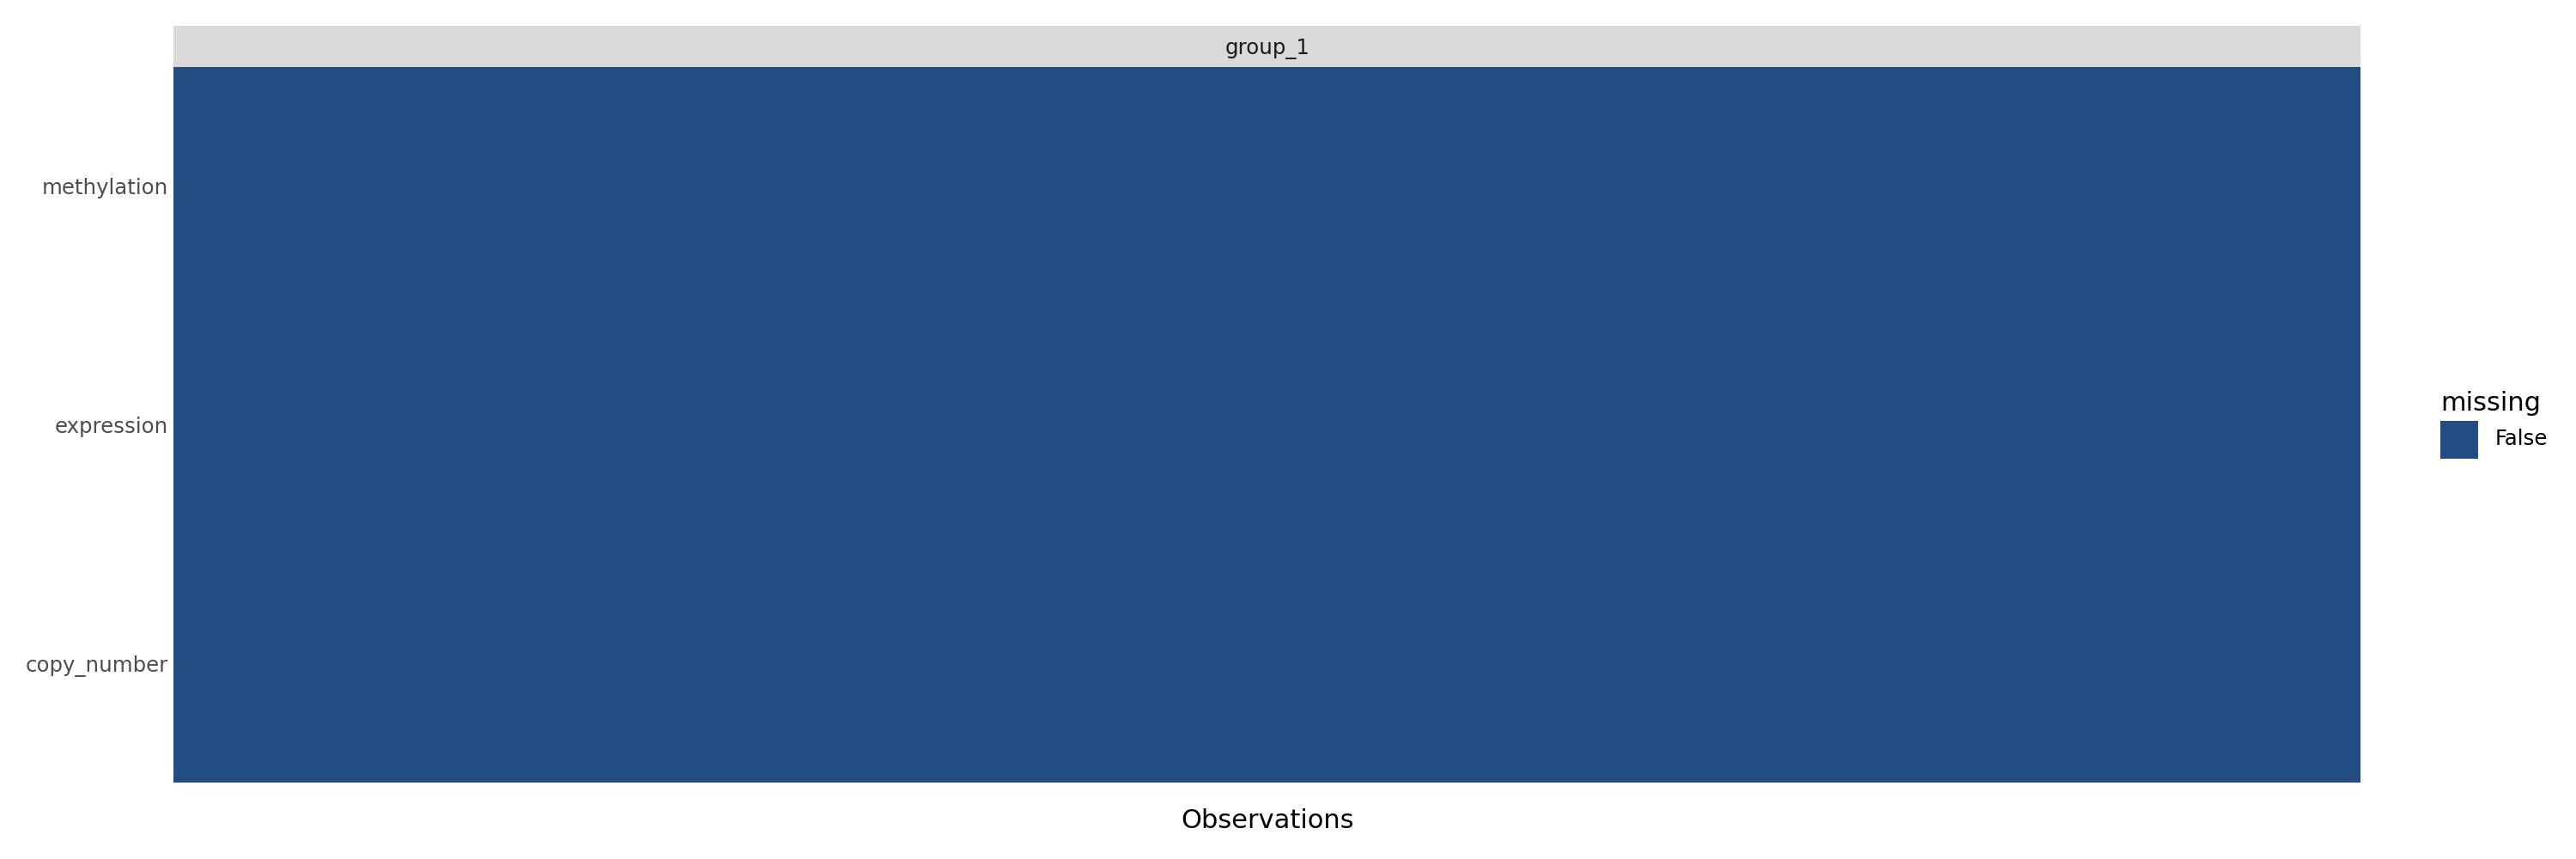

WARNING	Could not import dask. Data arrays may be copied, resulting in high memory usage.
f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
f:\BRACU\Thesis Thingy[T2510589]\P3 Coddy Stuffs\.env\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
INFO	Initializing factors using `random` method...


  0%|          | 0/10000 [00:00<?, ?epochs/s]

INFO	Training converged after 1609 epochs.


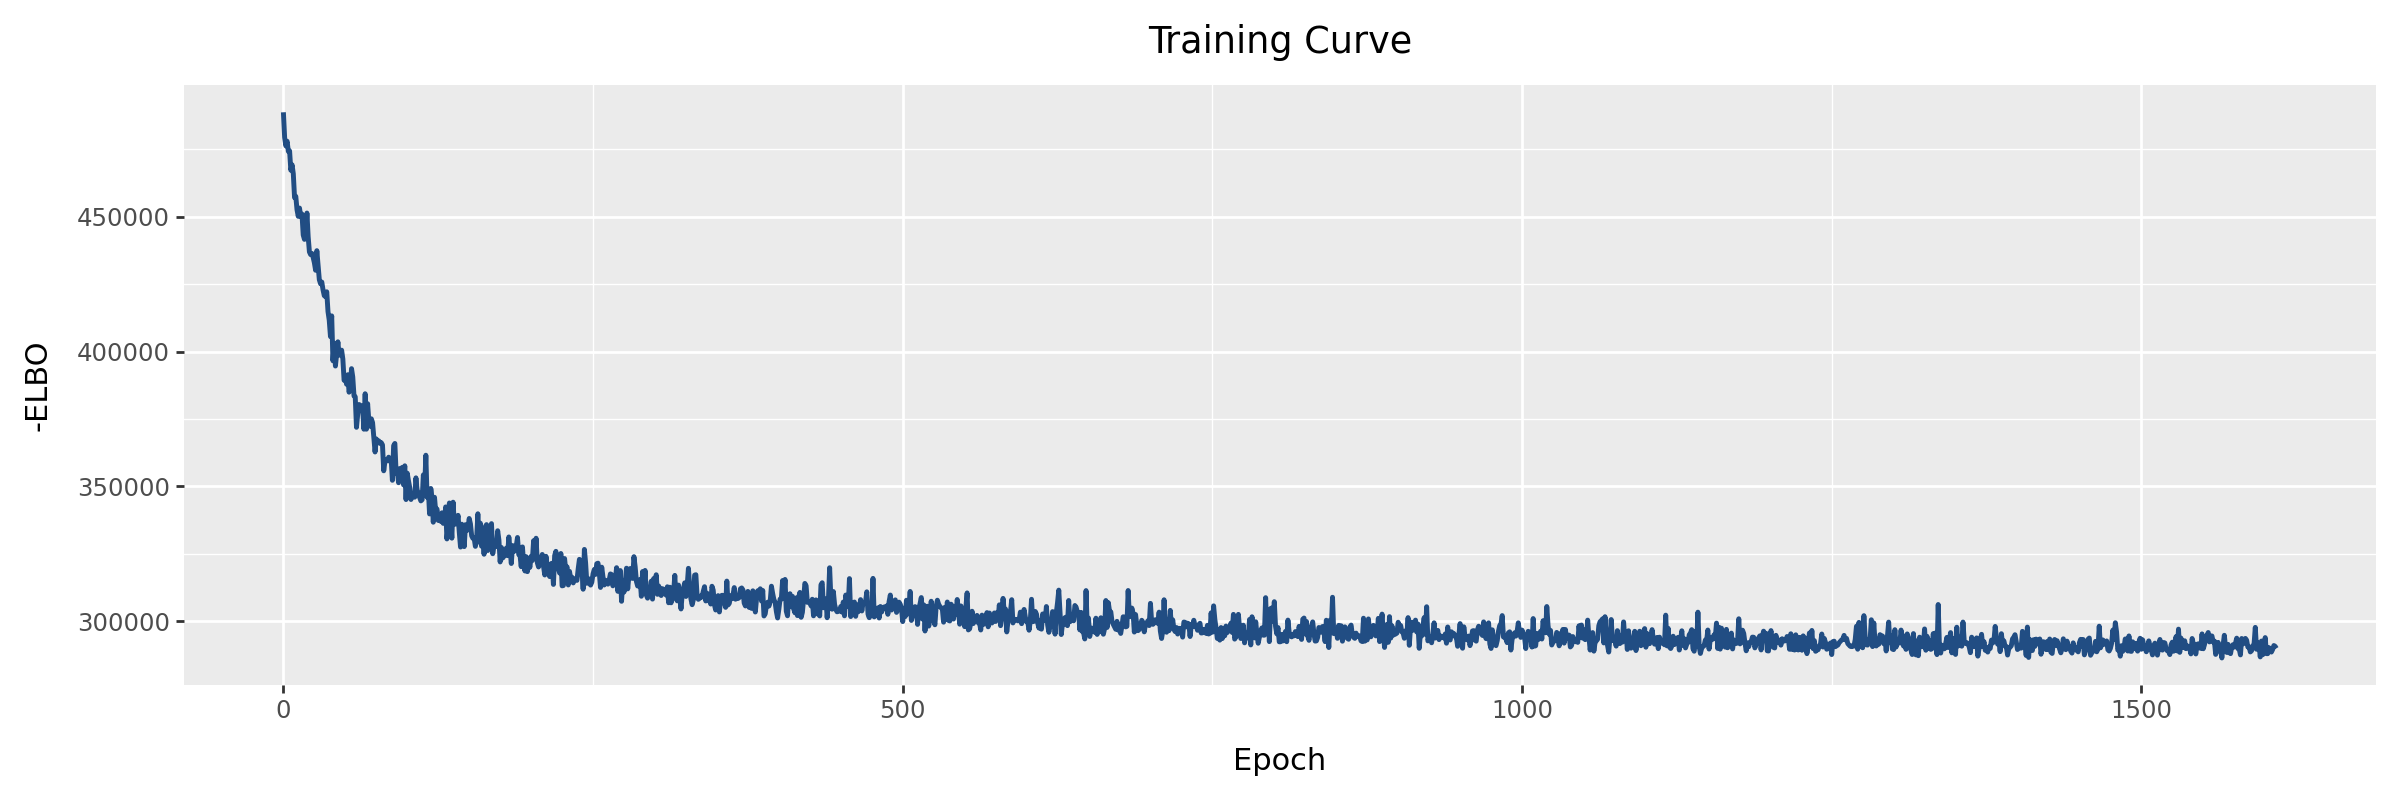

In [21]:
import mofaflex as mfl
import mudata as md

import torch

# 1. Prepare GPU
gpu_idx = mfl.tl.get_free_gpu_idx() 
device = f"cuda:{gpu_idx}" if (gpu_idx is not None and torch.cuda.is_available()) else "cpu"
print(f"Using device: {device}")

# 2. Create Views with Unique Feature Names (Fixes InvalidIndexError)
# We use .copy() to ensure we aren't modifying the original dataframes in a way that breaks things
mdata_dict = {
    "copy_number": ad.AnnData(copy_number_scaled.T.copy()),
    "methylation": ad.AnnData(methylation_scaled.T.copy()),
    "expression": ad.AnnData(expression_data_scaled.T.copy())
}

# Prefixing ensures that if 'Gene_A' exists in multiple views, they don't collide
for view_name, adata in mdata_dict.items():
    adata.var_names = [f"{view_name}_{name}" for name in adata.var_names]

# 3. Create MuData
mdata = md.MuData(mdata_dict)
print(f"MuData created successfully with {mdata.n_obs} samples.")

# 4. Train Model
# Note: Using "sns" in lowercase to match the internal registry
model = mfl.MOFAFLEX(
    mdata,
    mfl.ModelOptions(
        n_factors=15, 
        weight_prior="SpikeSlab", 
        likelihoods="Normal"
    ),
    mfl.TrainingOptions(
        device=device,
        seed=42, 
        lr=0.01, 
        early_stopper_patience=200,
        save_path=False 
    )
)

# 5. Visual Confirmation
mfl.pl.training_curve(model)

In [ ]:
factors_df = model.get_factors()
weights_dict = model.get_weights()

for view_name, df_weight in weights_dict.items():
    print(f"Weights shape for {view_name}:", df_weight.shape)

factors_data = model.get_factors()
if isinstance(factors_data, dict):
    first_group_key = list(factors_data.keys())[0]
    factors_df = factors_data[first_group_key]
    print(f"Extracted factors for group: {first_group_key}")
else:
    factors_df = factors_data
X = factors_df.to_numpy() 

print("Factors (X) shape:", X.shape)
y = subtype_encoded.loc[factors_df.index].values
print(f"Final training shapes: X={X.shape}, y={y.shape}")

Weights shape for copy_number: (56756, 15)
Weights shape for methylation: (396650, 15)
Weights shape for expression: (44635, 15)
Extracted factors for group: group_1
Factors (X) shape: (183, 15)
Final training shapes: X=(183, 15), y=(183,)


In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extract Factors from MOFAFLEX
# get_factors() returns a dict if groups exist, or a DataFrame if not
factors_output = model.get_factors()

if isinstance(factors_output, dict):
    # Automatically take the first group (e.g., 'group_1')
    group_name = list(factors_output.keys())[0]
    factors_df = factors_output[group_name]
    print(f"Extracted factors for: {group_name}")
else:
    factors_df = factors_output

# --- 2. MAP TO YOUR EXISTING VARIABLE NAMES ---
# This makes 'factors' available for your heatmap cell
factors = factors_df 

# This ensures 'common_samples' matches the MOFA sample order exactly
common_samples = factors_df.index 

# 3. Quick Verification
print(f"✅ Variables 'factors' and 'common_samples' are ready.")
print(f"📊 Matrix Shape: {factors.shape}")
print(f"🆔 First 5 Sample IDs: {list(common_samples[:5])}")

# 4. Weights (Optional info print)
weights_dict = model.get_weights()
for view, df_w in weights_dict.items():
    print(f"💡 View '{view}' contains {df_w.shape[0]} features.")

Extracted factors for: group_1
✅ Variables 'factors' and 'common_samples' are ready.
📊 Matrix Shape: (183, 15)
🆔 First 5 Sample IDs: ['TCGA-DX-A23Y-01A', 'TCGA-3B-A9HZ-01A', 'TCGA-DX-A240-01A', 'TCGA-3B-A9HX-01A', 'TCGA-3B-A9I3-01A']
💡 View 'copy_number' contains 56756 features.
💡 View 'methylation' contains 396650 features.
💡 View 'expression' contains 44635 features.


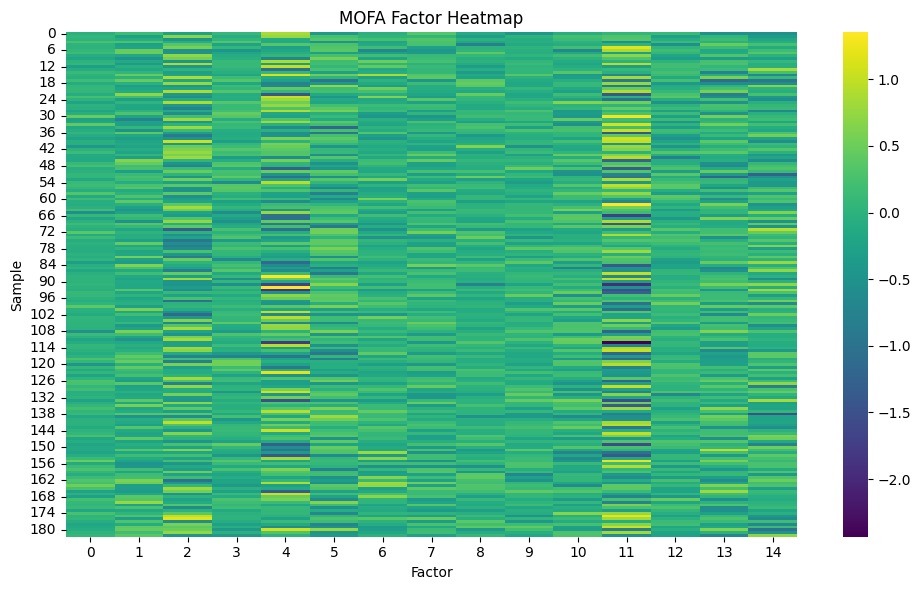

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# factors is already (n_samples × n_factors)
factor_array = np.array(factors)

# If you ever had only one sample, this ensures it's 2D
if factor_array.ndim == 1:
    factor_array = factor_array.reshape(1, -1)

plt.figure(figsize=(10, 6))
sns.heatmap(factor_array, cmap='viridis', annot=False)
plt.xlabel('Factor')
plt.ylabel('Sample')
plt.title('MOFA Factor Heatmap')
plt.tight_layout()
plt.show()


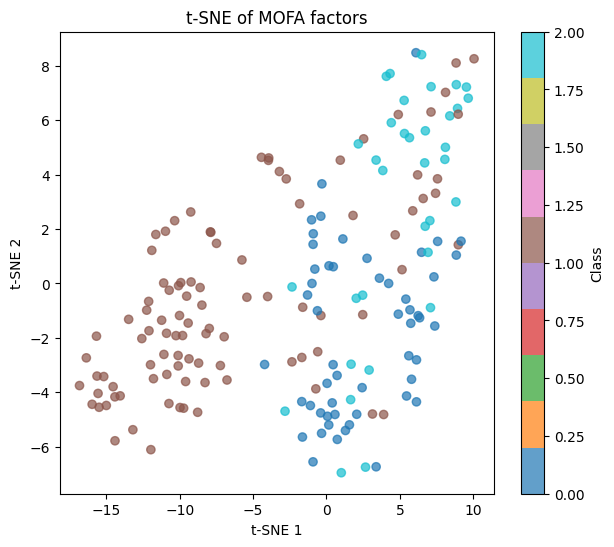

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
factors_2d = tsne.fit_transform(factors)

plt.figure(figsize=(7,6))
plt.scatter(factors_2d[:,0], factors_2d[:,1], c=subtype_encoded.values, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of MOFA factors")
plt.colorbar(label="Class")
plt.show()


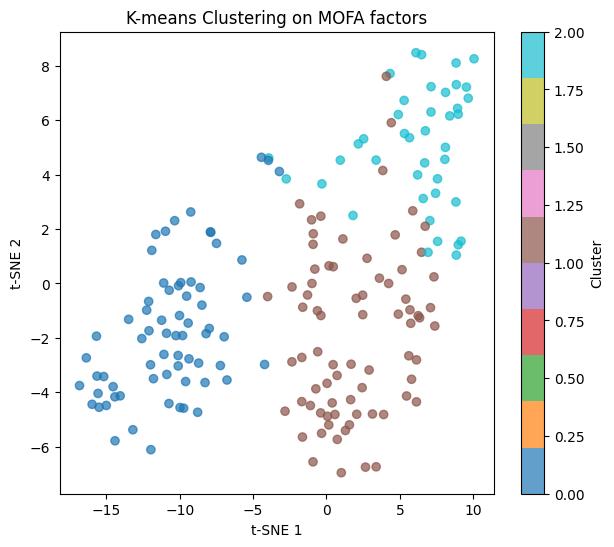

In [43]:
#kmeans clustering on the factors
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(factors)
labels = kmeans.labels_
plt.figure(figsize=(7,6))
plt.scatter(factors_2d[:,0], factors_2d[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("K-means Clustering on MOFA factors")
plt.colorbar(label="Cluster")
plt.show()

In [45]:
import numpy as np

# Get factor matrix (samples × factors)
# factors = ent.model.nodes["Z"].getExpectation()

# Compute L2 norm of each factor across samples
factor_norms = np.linalg.norm(factors, axis=0)

print("Factor norms:", factor_norms)
active_factors = np.sum(factor_norms > 1e-2)  # threshold can be adjusted
print(f"Active factors: {active_factors} / {factors.shape[1]}")


Factor norms: [ 2.2857082  3.9951835  7.156776   3.188951   8.577926   5.5142384
  3.658792   3.5384228  2.9393728  2.6892219  3.8742332 10.260663
  3.0964007  4.964365   5.322367 ]
Active factors: 15 / 15


In [46]:
# ===============================================
# MOFA CLUSTER QUALITY EVALUATION METRICS
# ===============================================

from sklearn.metrics import (silhouette_score, adjusted_rand_score, 
                           normalized_mutual_info_score, adjusted_mutual_info_score,
                           homogeneity_completeness_v_measure, calinski_harabasz_score,
                           davies_bouldin_score)
from sklearn.metrics.cluster import contingency_matrix
import numpy as np
import pandas as pd

print("🔍 MOFA CLUSTER QUALITY EVALUATION")
print("=" * 50)

# 1. INTERNAL CLUSTERING METRICS (using MOFA factors)
print("\n📊 INTERNAL CLUSTERING METRICS:")
print("-" * 30)

# Silhouette Score (Higher is better, range: -1 to 1)
sil_score = silhouette_score(factors, labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Calinski-Harabasz Score (Higher is better)
ch_score = calinski_harabasz_score(factors, labels)
print(f"Calinski-Harabasz Score: {ch_score:.4f}")

# Davies-Bouldin Score (Lower is better)
db_score = davies_bouldin_score(factors, labels)
print(f"Davies-Bouldin Score: {db_score:.4f}")

# 2. EXTERNAL VALIDATION METRICS (comparing with true subtypes)
print("\n🎯 EXTERNAL VALIDATION METRICS:")
print("-" * 30)

# Convert true labels to match clustering labels format
true_labels = subtype_encoded.values.flatten()

# Adjusted Rand Index (Higher is better, range: -1 to 1)
ari_score = adjusted_rand_score(true_labels, labels)
print(f"Adjusted Rand Index: {ari_score:.4f}")

# Normalized Mutual Information (Higher is better, range: 0 to 1)
nmi_score = normalized_mutual_info_score(true_labels, labels)
print(f"Normalized Mutual Information: {nmi_score:.4f}")

# Adjusted Mutual Information (Higher is better, range: -1 to 1)
ami_score = adjusted_mutual_info_score(true_labels, labels)
print(f"Adjusted Mutual Information: {ami_score:.4f}")

# Homogeneity, Completeness, V-measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, labels)
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-measure: {v_measure:.4f}")

# 3. CLUSTER COMPOSITION ANALYSIS
print("\n📈 CLUSTER COMPOSITION ANALYSIS:")
print("-" * 30)

# Create contingency table
cont_matrix = contingency_matrix(true_labels, labels)
print("Contingency Matrix (True Labels vs Predicted Clusters):")
print(cont_matrix)

# Cluster purity
cluster_purity = np.sum(np.max(cont_matrix, axis=0)) / np.sum(cont_matrix)
print(f"\nCluster Purity: {cluster_purity:.4f}")

# 4. FACTOR QUALITY METRICS
print("\n🔬 MOFA FACTOR QUALITY METRICS:")
print("-" * 30)

# Factor variance explained
factor_variance = np.var(factors, axis=0)
total_variance = np.sum(factor_variance)
variance_explained = factor_variance / total_variance * 100

print("Factor Variance Explained (%):")
for i, var_exp in enumerate(variance_explained):
    print(f"  Factor {i+1}: {var_exp:.2f}%")

print(f"\nTop 5 factors explain: {np.sum(variance_explained[:5]):.2f}% of variance")

# Factor separability (mean distance between cluster centroids)
unique_labels = np.unique(labels)
centroids = []
for label in unique_labels:
    centroid = np.mean(factors[labels == label], axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)
pairwise_distances = []
for i in range(len(centroids)):
    for j in range(i+1, len(centroids)):
        dist = np.linalg.norm(centroids[i] - centroids[j])
        pairwise_distances.append(dist)

mean_centroid_distance = np.mean(pairwise_distances)
print(f"Mean Inter-cluster Distance: {mean_centroid_distance:.4f}")

# 5. OVERALL QUALITY SUMMARY
print("\n🏆 OVERALL QUALITY SUMMARY:")
print("-" * 30)

# Create a composite score (weighted average of key metrics)
composite_score = (
    0.3 * sil_score +           # Internal consistency
    0.3 * ari_score +           # Agreement with true labels
    0.2 * nmi_score +           # Information shared with true labels
    0.2 * cluster_purity        # Cluster purity
)

print(f"Composite Quality Score: {composite_score:.4f}")

# Quality interpretation
if composite_score > 0.7:
    quality_rating = "Excellent"
elif composite_score > 0.5:
    quality_rating = "Good"
elif composite_score > 0.3:
    quality_rating = "Fair"
else:
    quality_rating = "Poor"

print(f"Overall Rating: {quality_rating}")

print("\n💡 INTERPRETATION GUIDE:")
print("- Silhouette Score: >0.7=Excellent, 0.5-0.7=Good, 0.25-0.5=Fair, <0.25=Poor")
print("- ARI: >0.9=Excellent, 0.8-0.9=Good, 0.6-0.8=Fair, <0.6=Poor")
print("- NMI: >0.9=Excellent, 0.7-0.9=Good, 0.5-0.7=Fair, <0.5=Poor")

🔍 MOFA CLUSTER QUALITY EVALUATION

📊 INTERNAL CLUSTERING METRICS:
------------------------------
Silhouette Score: 0.2085
Calinski-Harabasz Score: 53.0854
Davies-Bouldin Score: 1.6428

🎯 EXTERNAL VALIDATION METRICS:
------------------------------
Adjusted Rand Index: 0.3762
Normalized Mutual Information: 0.3720
Adjusted Mutual Information: 0.3652
Homogeneity: 0.3827
Completeness: 0.3618
V-measure: 0.3720

📈 CLUSTER COMPOSITION ANALYSIS:
------------------------------
Contingency Matrix (True Labels vs Predicted Clusters):
[[ 1 47  5]
 [66 14 16]
 [ 0 14 20]]

Cluster Purity: 0.7268

🔬 MOFA FACTOR QUALITY METRICS:
------------------------------
Factor Variance Explained (%):
  Factor 1: 1.27%
  Factor 2: 3.88%
  Factor 3: 12.46%
  Factor 4: 2.47%
  Factor 5: 17.89%
  Factor 6: 7.39%
  Factor 7: 3.26%
  Factor 8: 3.04%
  Factor 9: 2.10%
  Factor 10: 1.76%
  Factor 11: 3.65%
  Factor 12: 25.60%
  Factor 13: 2.33%
  Factor 14: 5.99%
  Factor 15: 6.89%

Top 5 factors explain: 37.98% of vari

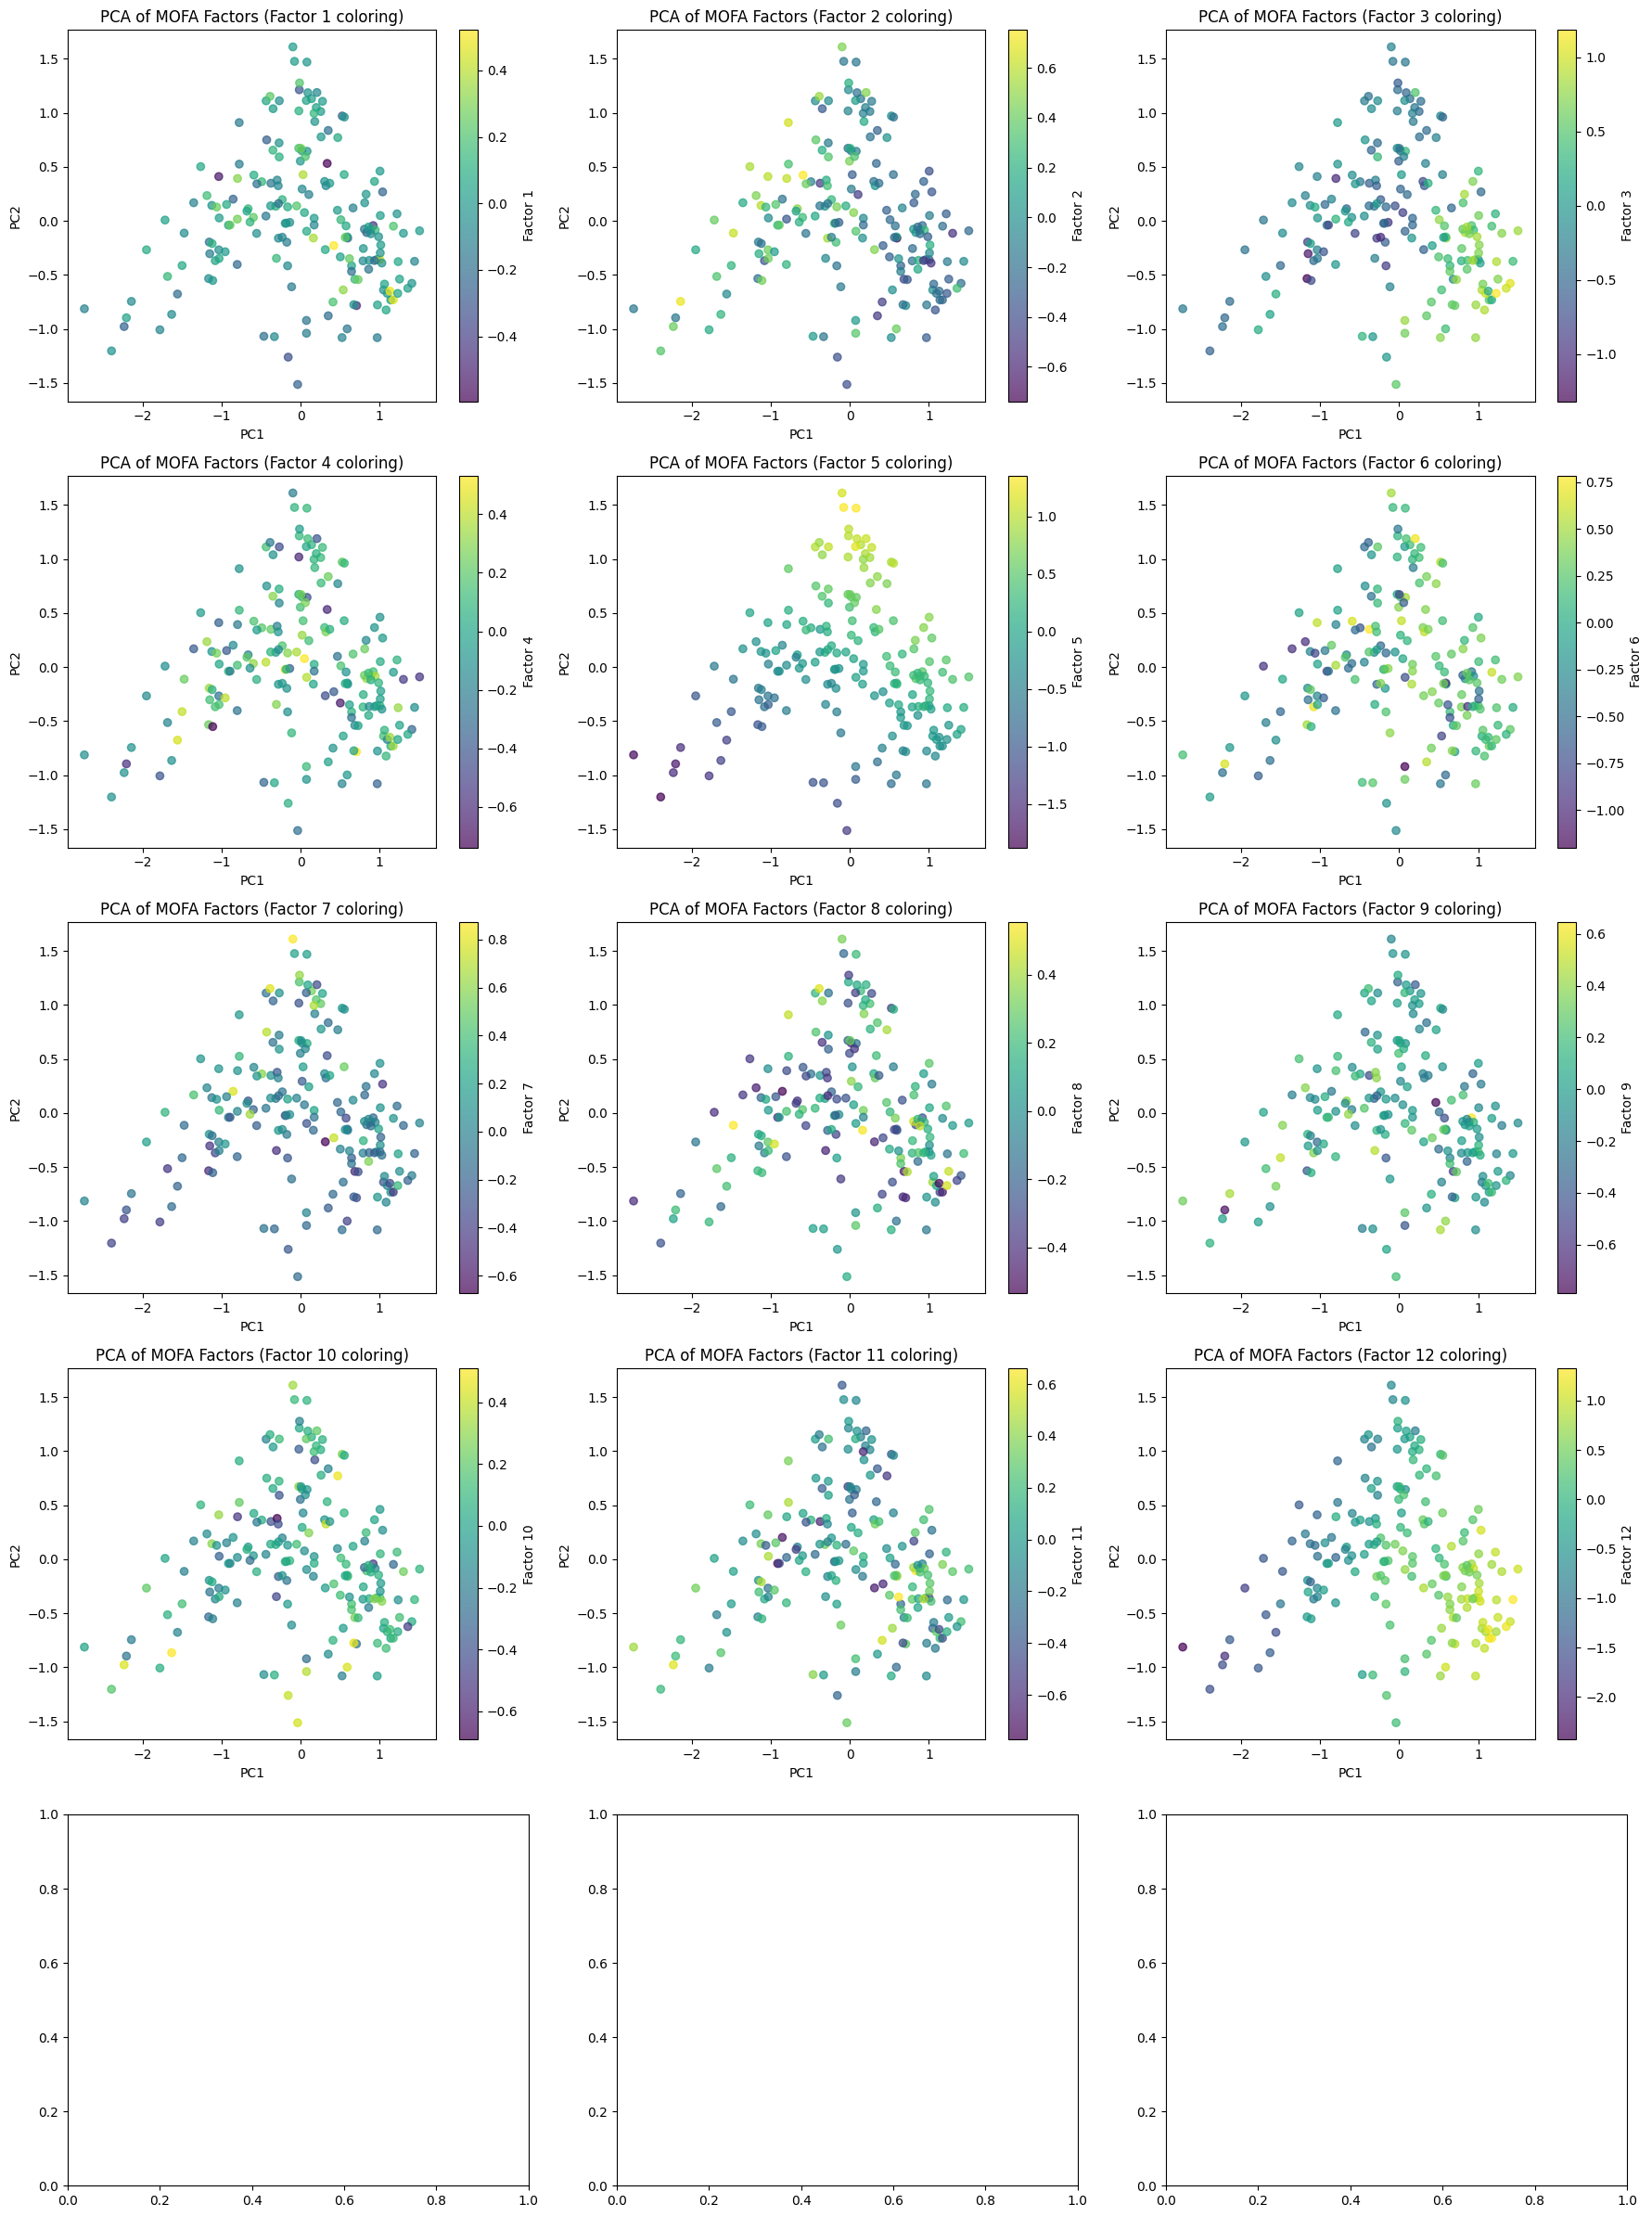

In [47]:
# PCA plots for all 15 MOFA factors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# factors: (n_samples, n_factors)
factors_array = np.array(factors)
labels = subtype_encoded.loc[common_samples].values

pca = PCA(n_components=2)

fig, axes = plt.subplots(5, 3, figsize=(18, 24))
axes = axes.flatten()

for i in range(12):
    # For each factor, use all factors for PCA, but color by the i-th factor
    pca_result = pca.fit_transform(factors_array)
    ax = axes[i]
    scatter = ax.scatter(pca_result[:,0], pca_result[:,1], c=factors_array[:,i], cmap='viridis', alpha=0.7)
    ax.set_title(f'PCA of MOFA Factors (Factor {i+1} coloring)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax, label=f'Factor {i+1}')

plt.tight_layout()
plt.show()

# Data Splitting for ML and NN Models

In [52]:
# ====================================================================
# CENTRALIZED DATA SPLITTING FOR ALL ML AND NN MODELS
# ====================================================================
# This cell creates train/validation/test splits used by all models
# Each disease subtype is split 80/20 independently, then merged
# to ensure consistent comparison across different classifiers
# ====================================================================

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Prepare features and labels from MOFA factors
X = np.array(factors)  # MOFA factors: samples × factors
y = subtype_encoded.loc[common_samples].values  # Encoded subtype labels

print("="*70)
print("STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE")
print("="*70)
print(f"\n📊 Total samples: {len(X)}")
print(f"\n🔬 Disease subtype distribution:")

# Get unique disease subtypes
unique_subtypes = np.unique(y)
subtype_names = label_encoder.classes_

for subtype_idx, subtype_name in zip(unique_subtypes, subtype_names):
    count = np.sum(y == subtype_idx)
    print(f"   - {subtype_name}: {count} samples")

# ====================================================================
# SPLIT 1: For Traditional ML Models (Logistic Regression, RF, SVM, etc.)
# ====================================================================
# Split each disease subtype 80/20, then merge
print(f"\n{'='*70}")
print("🔹 ML Models Split (Train/Test) - Stratified by Disease:")
print(f"{'='*70}")

X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for subtype_idx in unique_subtypes:
    # Get samples for this subtype
    subtype_mask = (y == subtype_idx)
    X_subtype = X[subtype_mask]
    y_subtype = y[subtype_mask]
    
    # Split this subtype 80/20
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        X_subtype, y_subtype, test_size=0.2, random_state=42
    )
    
    X_train_list.append(X_train_sub)
    X_test_list.append(X_test_sub)
    y_train_list.append(y_train_sub)
    y_test_list.append(y_test_sub)
    
    subtype_name = subtype_names[subtype_idx]
    print(f"   {subtype_name}:")
    print(f"      Train: {len(X_train_sub)} samples ({len(X_train_sub)/len(X_subtype)*100:.1f}%)")
    print(f"      Test:  {len(X_test_sub)} samples ({len(X_test_sub)/len(X_subtype)*100:.1f}%)")

# Merge all subtypes
X_train = np.vstack(X_train_list)
X_test = np.vstack(X_test_list)
y_train = np.concatenate(y_train_list)
y_test = np.concatenate(y_test_list)

print(f"\n📦 Merged ML splits:")
print(f"   - Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify distribution in train and test
print(f"\n📊 Disease distribution in splits:")
for subtype_idx, subtype_name in zip(unique_subtypes, subtype_names):
    train_count = np.sum(y_train == subtype_idx)
    test_count = np.sum(y_test == subtype_idx)
    print(f"   {subtype_name}:")
    print(f"      Train: {train_count} ({train_count/len(y_train)*100:.1f}%)")
    print(f"      Test:  {test_count} ({test_count/len(y_test)*100:.1f}%)")

# ====================================================================
# SPLIT 2: For Neural Network Models (MLP, AE)
# ====================================================================
# Three-way split: train/validation/test (64/16/20) for each subtype
print(f"\n{'='*70}")
print("🔹 Neural Network Models Split (Train/Val/Test) - Stratified by Disease:")
print(f"{'='*70}")

X_train_nn_list = []
X_val_nn_list = []
X_test_nn_list = []
y_train_nn_list = []
y_val_nn_list = []
y_test_nn_list = []

for subtype_idx in unique_subtypes:
    # Get samples for this subtype
    subtype_mask = (y == subtype_idx)
    X_subtype = X[subtype_mask]
    y_subtype = y[subtype_mask]
    
    # First split: separate test set (20%)
    X_trainval_sub, X_test_nn_sub, y_trainval_sub, y_test_nn_sub = train_test_split(
        X_subtype, y_subtype, test_size=0.2, random_state=42
    )
    # Second split: separate validation from training (20% of remaining = 16% of total)
    X_train_nn_sub, X_val_nn_sub, y_train_nn_sub, y_val_nn_sub = train_test_split(
        X_trainval_sub, y_trainval_sub, test_size=0.2, random_state=42
    )
    
    X_train_nn_list.append(X_train_nn_sub)
    X_val_nn_list.append(X_val_nn_sub)
    X_test_nn_list.append(X_test_nn_sub)
    y_train_nn_list.append(y_train_nn_sub)
    y_val_nn_list.append(y_val_nn_sub)
    y_test_nn_list.append(y_test_nn_sub)
    
    subtype_name = subtype_names[subtype_idx]
    print(f"   {subtype_name}:")
    print(f"      Train: {len(X_train_nn_sub)} samples ({len(X_train_nn_sub)/len(X_subtype)*100:.1f}%)")
    print(f"      Val:   {len(X_val_nn_sub)} samples ({len(X_val_nn_sub)/len(X_subtype)*100:.1f}%)")
    print(f"      Test:  {len(X_test_nn_sub)} samples ({len(X_test_nn_sub)/len(X_subtype)*100:.1f}%)")

# Merge all subtypes
X_train_nn = np.vstack(X_train_nn_list)
X_val_nn = np.vstack(X_val_nn_list)
X_test_nn = np.vstack(X_test_nn_list)
y_train_nn = np.concatenate(y_train_nn_list)
y_val_nn = np.concatenate(y_val_nn_list)
y_test_nn = np.concatenate(y_test_nn_list)

print(f"\n📦 Merged NN splits:")
print(f"   - Training set: {len(X_train_nn)} samples ({len(X_train_nn)/len(X)*100:.1f}%)")
print(f"   - Validation set: {len(X_val_nn)} samples ({len(X_val_nn)/len(X)*100:.1f}%)")
print(f"   - Test set: {len(X_test_nn)} samples ({len(X_test_nn)/len(X)*100:.1f}%)")

# Verify distribution in train/val/test
print(f"\n📊 Disease distribution in NN splits:")
for subtype_idx, subtype_name in zip(unique_subtypes, subtype_names):
    train_count = np.sum(y_train_nn == subtype_idx)
    val_count = np.sum(y_val_nn == subtype_idx)
    test_count = np.sum(y_test_nn == subtype_idx)
    print(f"   {subtype_name}:")
    print(f"      Train: {train_count} ({train_count/len(y_train_nn)*100:.1f}%)")
    print(f"      Val:   {val_count} ({val_count/len(y_val_nn)*100:.1f}%)")
    print(f"      Test:  {test_count} ({test_count/len(y_test_nn)*100:.1f}%)")

# ====================================================================
# Convert NN splits to PyTorch tensors
# ====================================================================
X_train_t = torch.tensor(X_train_nn, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val_nn, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test_nn, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_nn, dtype=torch.long).to(device)
y_val_t = torch.tensor(y_val_nn, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_test_nn, dtype=torch.long).to(device)

print(f"\n✅ Data splits created successfully with stratification by disease!")
print(f"   - ML models use: X_train, X_test, y_train, y_test")
print(f"   - NN models use: X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t")
print("="*70)

STRATIFIED DATA SPLITTING BY DISEASE SUBTYPE

📊 Total samples: 183

🔬 Disease subtype distribution:
   - Dedifferentiated liposarcoma: 53 samples
   - Leiomyosarcoma, NOS: 96 samples
   - Undifferentiated sarcoma: 34 samples

🔹 ML Models Split (Train/Test) - Stratified by Disease:
   Dedifferentiated liposarcoma:
      Train: 42 samples (79.2%)
      Test:  11 samples (20.8%)
   Leiomyosarcoma, NOS:
      Train: 76 samples (79.2%)
      Test:  20 samples (20.8%)
   Undifferentiated sarcoma:
      Train: 27 samples (79.4%)
      Test:  7 samples (20.6%)

📦 Merged ML splits:
   - Training set: 145 samples (79.2%)
   - Test set: 38 samples (20.8%)

📊 Disease distribution in splits:
   Dedifferentiated liposarcoma:
      Train: 42 (29.0%)
      Test:  11 (28.9%)
   Leiomyosarcoma, NOS:
      Train: 76 (52.4%)
      Test:  20 (52.6%)
   Undifferentiated sarcoma:
      Train: 27 (18.6%)
      Test:  7 (18.4%)

🔹 Neural Network Models Split (Train/Val/Test) - Stratified by Disease:
   Dediffe

🧪 TESTING ML_CLASSIFIER.PY MODULE

📦 Using train_classifiers() convenience function...
Training and evaluating classifiers...
  Training Random Forest...
  Training Gradient Boosting...
  Training SVM (RBF)...
  Training SVM (Linear)...
  Training Logistic Regression...
  Training K-Nearest Neighbors...
  Training Naive Bayes...
  Training Decision Tree...
  Training XGBoost...
✅ Trained and evaluated 9 classifiers

ML CLASSIFIER RESULTS
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
          SVM (RBF)  0.815789           0.778469           0.815789        0.807792        0.815789    0.788288    0.815789 0.880249
Logistic Regression  0.789474           0.747619           0.789474        0.729221        0.789474    0.732945    0.789474 0.899750
K-Nearest Neighbors  0.763158           0.728186           0.763158        0.726190        0.763158    0.706349    0.763158 0.874688
      Random Forest  0.736

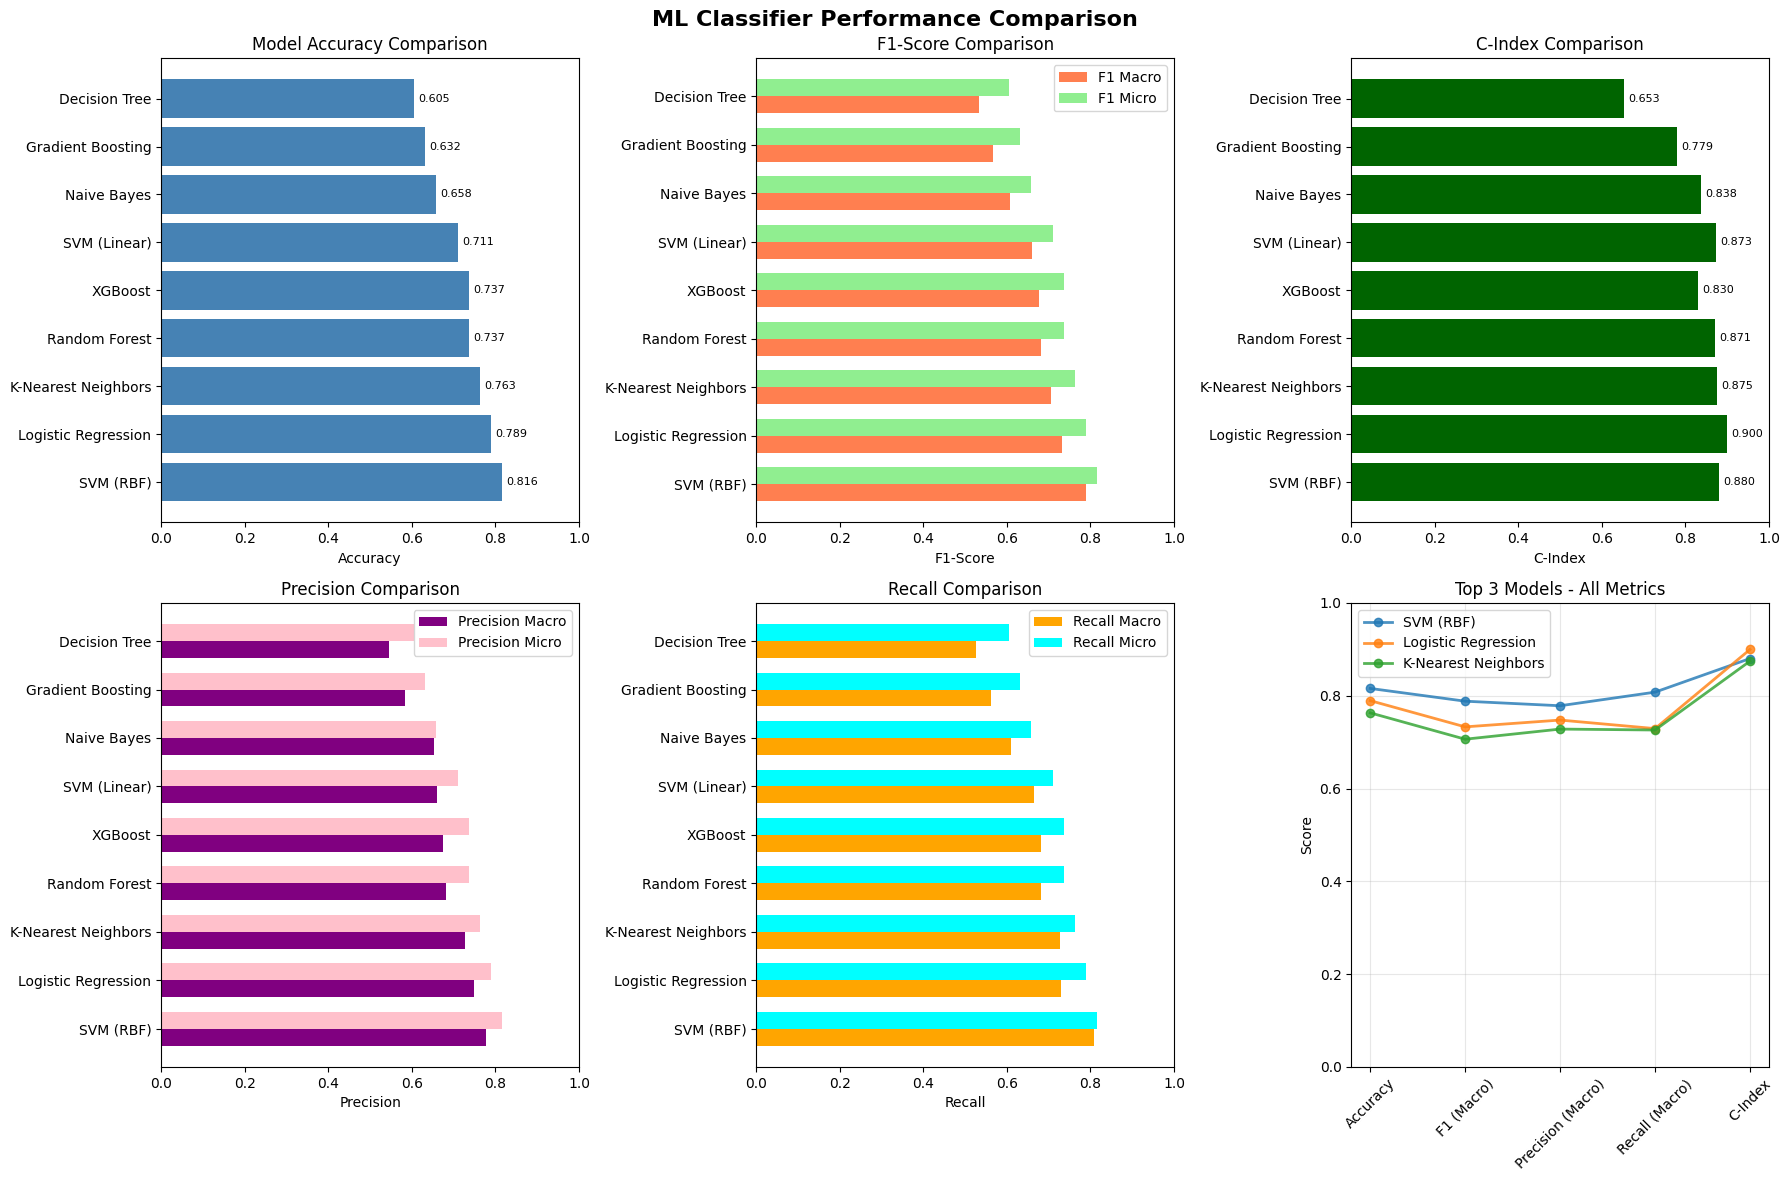


📉 Plotting ROC curves...


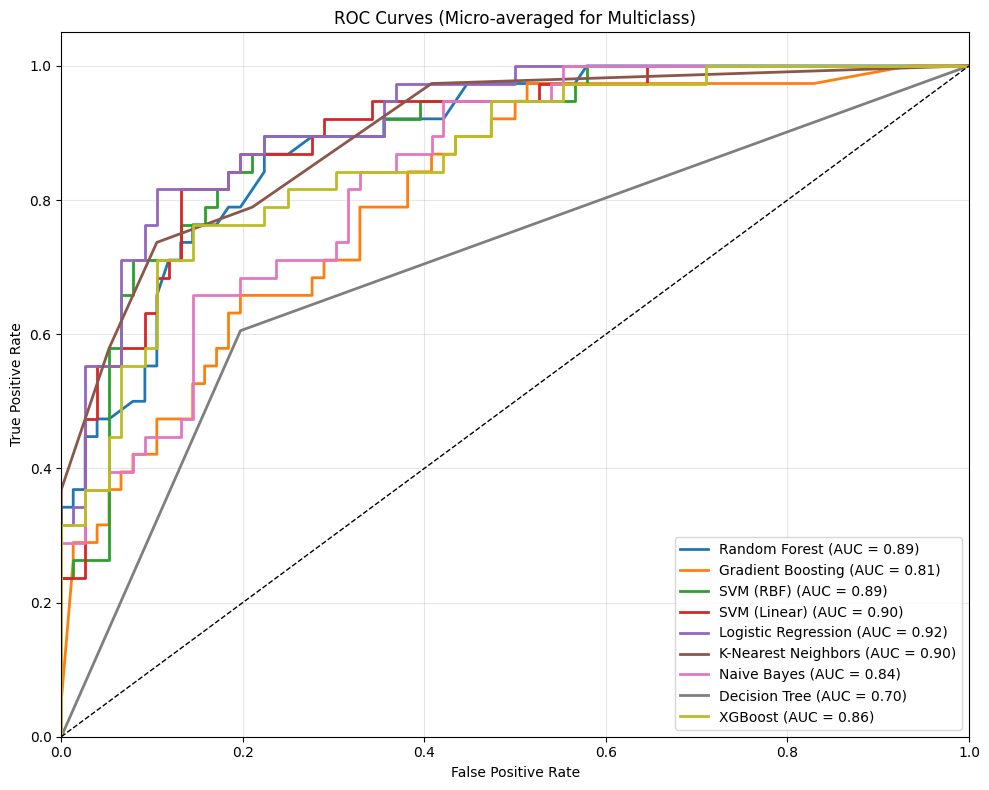


🔲 Plotting confusion matrices...


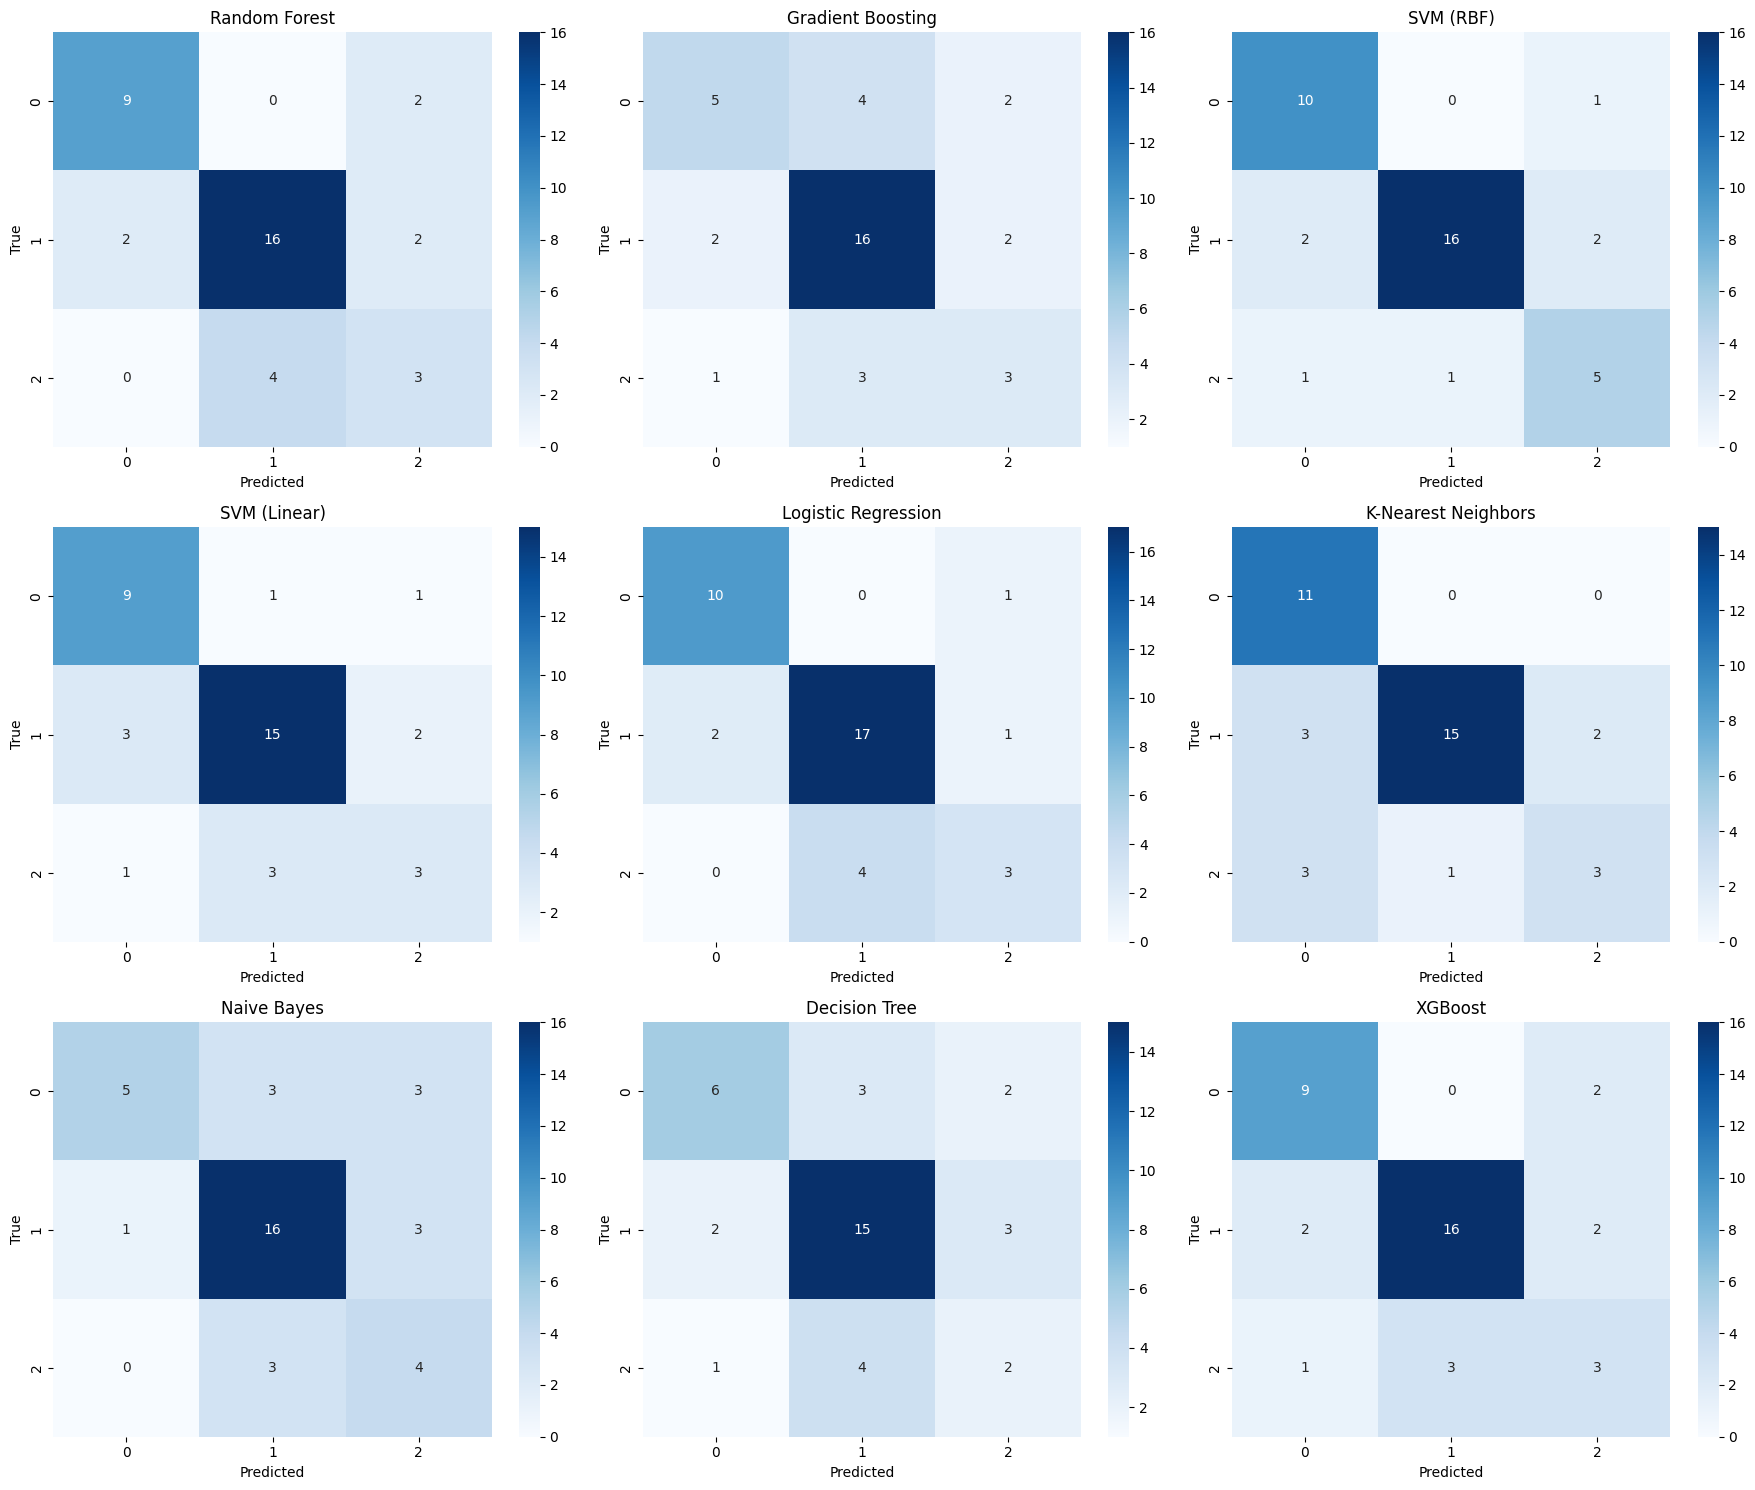


CLASSIFICATION REPORTS (Top 3 Models)

📋 SVM (RBF):
------------------------------------------------------------
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma     0.7692    0.9091    0.8333        11
         Leiomyosarcoma, NOS     0.9412    0.8000    0.8649        20
    Undifferentiated sarcoma     0.6250    0.7143    0.6667         7

                    accuracy                         0.8158        38
                   macro avg     0.7785    0.8078    0.7883        38
                weighted avg     0.8332    0.8158    0.8192        38


📋 Logistic Regression:
------------------------------------------------------------
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma     0.8333    0.9091    0.8696        11
         Leiomyosarcoma, NOS     0.8095    0.8500    0.8293        20
    Undifferentiated sarcoma     0.6000    0.4286    0.5000         7

                    accura

In [53]:
# ====================================================================
# TESTING ML_CLASSIFIER.PY MODULE
# ====================================================================
# This cell uses the ml_classifier module for comparison with the
# individual models trained above

from ml_classifier import MLClassifier, train_classifiers

print("="*80)
print("🧪 TESTING ML_CLASSIFIER.PY MODULE")
print("="*80)

# Method 1: Using the convenience function
print("\n📦 Using train_classifiers() convenience function...")
ml_clf = train_classifiers(
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test,
    random_state=42,
    include_xgboost=True,
    verbose=True
)

# Print results table
ml_clf.print_results(sort_by='Accuracy')

# Get results as DataFrame for comparison
ml_results_df = ml_clf.get_results_dataframe(sort_by='Accuracy')
print("\n📊 Results DataFrame from ml_classifier module:")
print(ml_results_df)

# Plot performance comparison
print("\n📈 Plotting results...")
ml_clf.plot_results()

# Plot ROC curves
print("\n📉 Plotting ROC curves...")
ml_clf.plot_roc_curves()

# Plot confusion matrices
print("\n🔲 Plotting confusion matrices...")
ml_clf.plot_confusion_matrices()

# Get classification reports for top 3 models
print("\n" + "="*80)
print("CLASSIFICATION REPORTS (Top 3 Models)")
print("="*80)

top_models = ml_results_df.head(3)['Model'].tolist()
for model_name in top_models:
    print(f"\n📋 {model_name}:")
    print("-"*60)
    print(ml_clf.get_classification_report(model_name, target_names=label_encoder.classes_))

# Get best model info
best_name, best_model, best_result = ml_clf.get_best_model(metric='Accuracy')
print("\n" + "="*80)
print(f"🏆 BEST MODEL FROM ML_CLASSIFIER MODULE: {best_name}")
print("="*80)
print(f"   Accuracy:        {best_result['Accuracy']:.4f}")
print(f"   F1 (Macro):      {best_result['F1 (Macro)']:.4f}")
print(f"   Precision (Macro): {best_result['Precision (Macro)']:.4f}")
print(f"   Recall (Macro):  {best_result['Recall (Macro)']:.4f}")
print(f"   C-Index:         {best_result['C-Index']:.4f}")

print("\n✅ ml_classifier.py module test completed successfully!")

In [54]:
# ====================================================================
# ENSEMBLE MODELS - Using the ensemble module
# ====================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from ensemble import (
    VotingEnsemble,
    StackingEnsemble,
    WeightedAverageEnsemble,
    BaggingEnsemble,
    BoostingEnsemble,
    create_default_classifiers,
    evaluate_ensemble,
    evaluate_multiple_ensembles
)

print("="*70)
print("TRAINING ENSEMBLE MODELS")
print("="*70)

# Create base classifiers
base_classifiers = create_default_classifiers(random_state=42)

# Dictionary to store all trained ensembles
ensembles = {}

# 1. Voting Ensemble (Soft)
print("\n🔹 Training Voting Ensemble (Soft)...")
voting_soft = VotingEnsemble(create_default_classifiers(random_state=42), voting='soft')
voting_soft.fit(X_train, y_train)
ensembles['Voting (Soft)'] = voting_soft

# 2. Voting Ensemble (Hard)
print("\n🔹 Training Voting Ensemble (Hard)...")
voting_hard = VotingEnsemble(create_default_classifiers(random_state=42), voting='hard')
voting_hard.fit(X_train, y_train)
ensembles['Voting (Hard)'] = voting_hard

# 3. Stacking Ensemble
print("\n🔹 Training Stacking Ensemble...")
stacking = StackingEnsemble(
    create_default_classifiers(random_state=42),
    meta_classifier=LogisticRegression(max_iter=1000)
)
stacking.fit(X_train, y_train)
ensembles['Stacking'] = stacking

# 4. Weighted Average Ensemble
print("\n🔹 Training Weighted Average Ensemble...")
weighted = WeightedAverageEnsemble(
    create_default_classifiers(random_state=42),
    weights='accuracy'
)
weighted.fit(X_train, y_train)
ensembles['Weighted Average'] = weighted

# 5. Bagging Ensemble
print("\n🔹 Training Bagging Ensemble...")
bagging = BaggingEnsemble(
    base_classifier=RandomForestClassifier(n_estimators=50, random_state=42),
    n_estimators=10,
    random_state=42
)
bagging.fit(X_train, y_train)
ensembles['Bagging'] = bagging

# 6. Boosting Ensemble (AdaBoost)
print("\n🔹 Training Boosting Ensemble (AdaBoost)...")
boosting = BoostingEnsemble(n_estimators=50, random_state=42)
boosting.fit(X_train, y_train)
ensembles['Boosting (AdaBoost)'] = boosting

print("\n✅ All ensemble models trained successfully!")
print(f"   Total ensembles: {len(ensembles)}")

TRAINING ENSEMBLE MODELS

🔹 Training Voting Ensemble (Soft)...
Training Random Forest...
Training Gradient Boosting...
Training SVM (RBF)...
Training SVM (Linear)...
Training Logistic Regression...
Training K-Nearest Neighbors...
Training Naive Bayes...
Training Decision Tree...
Training XGBoost...

🔹 Training Voting Ensemble (Hard)...
Training Random Forest...
Training Gradient Boosting...
Training SVM (RBF)...
Training SVM (Linear)...
Training Logistic Regression...
Training K-Nearest Neighbors...
Training Naive Bayes...
Training Decision Tree...
Training XGBoost...

🔹 Training Stacking Ensemble...
Generating meta-features using cross-validation...
Fitting base classifiers on full training data...
  Training Random Forest...
  Training Gradient Boosting...
  Training SVM (RBF)...
  Training SVM (Linear)...
  Training Logistic Regression...
  Training K-Nearest Neighbors...
  Training Naive Bayes...
  Training Decision Tree...
  Training XGBoost...
Fitting meta-classifier...

🔹 Traini

ENSEMBLE MODELS EVALUATION RESULTS

📊 ENSEMBLE PERFORMANCE COMPARISON:
--------------------------------------------------------------------------------
              Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
Boosting (AdaBoost)  0.763158           0.723906           0.763158        0.747186        0.763158    0.731459    0.763158 0.878484
      Voting (Hard)  0.736842           0.683333           0.736842        0.682251        0.736842    0.681382    0.736842 0.863570
      Voting (Soft)  0.710526           0.651948           0.710526        0.651948        0.710526    0.651948    0.710526 0.863570
   Weighted Average  0.710526           0.651948           0.710526        0.651948        0.710526    0.651948    0.710526 0.866032
            Bagging  0.710526           0.646377           0.710526        0.620996        0.710526    0.628645    0.710526 0.857111
           Stacking  0.657895           0.607504  

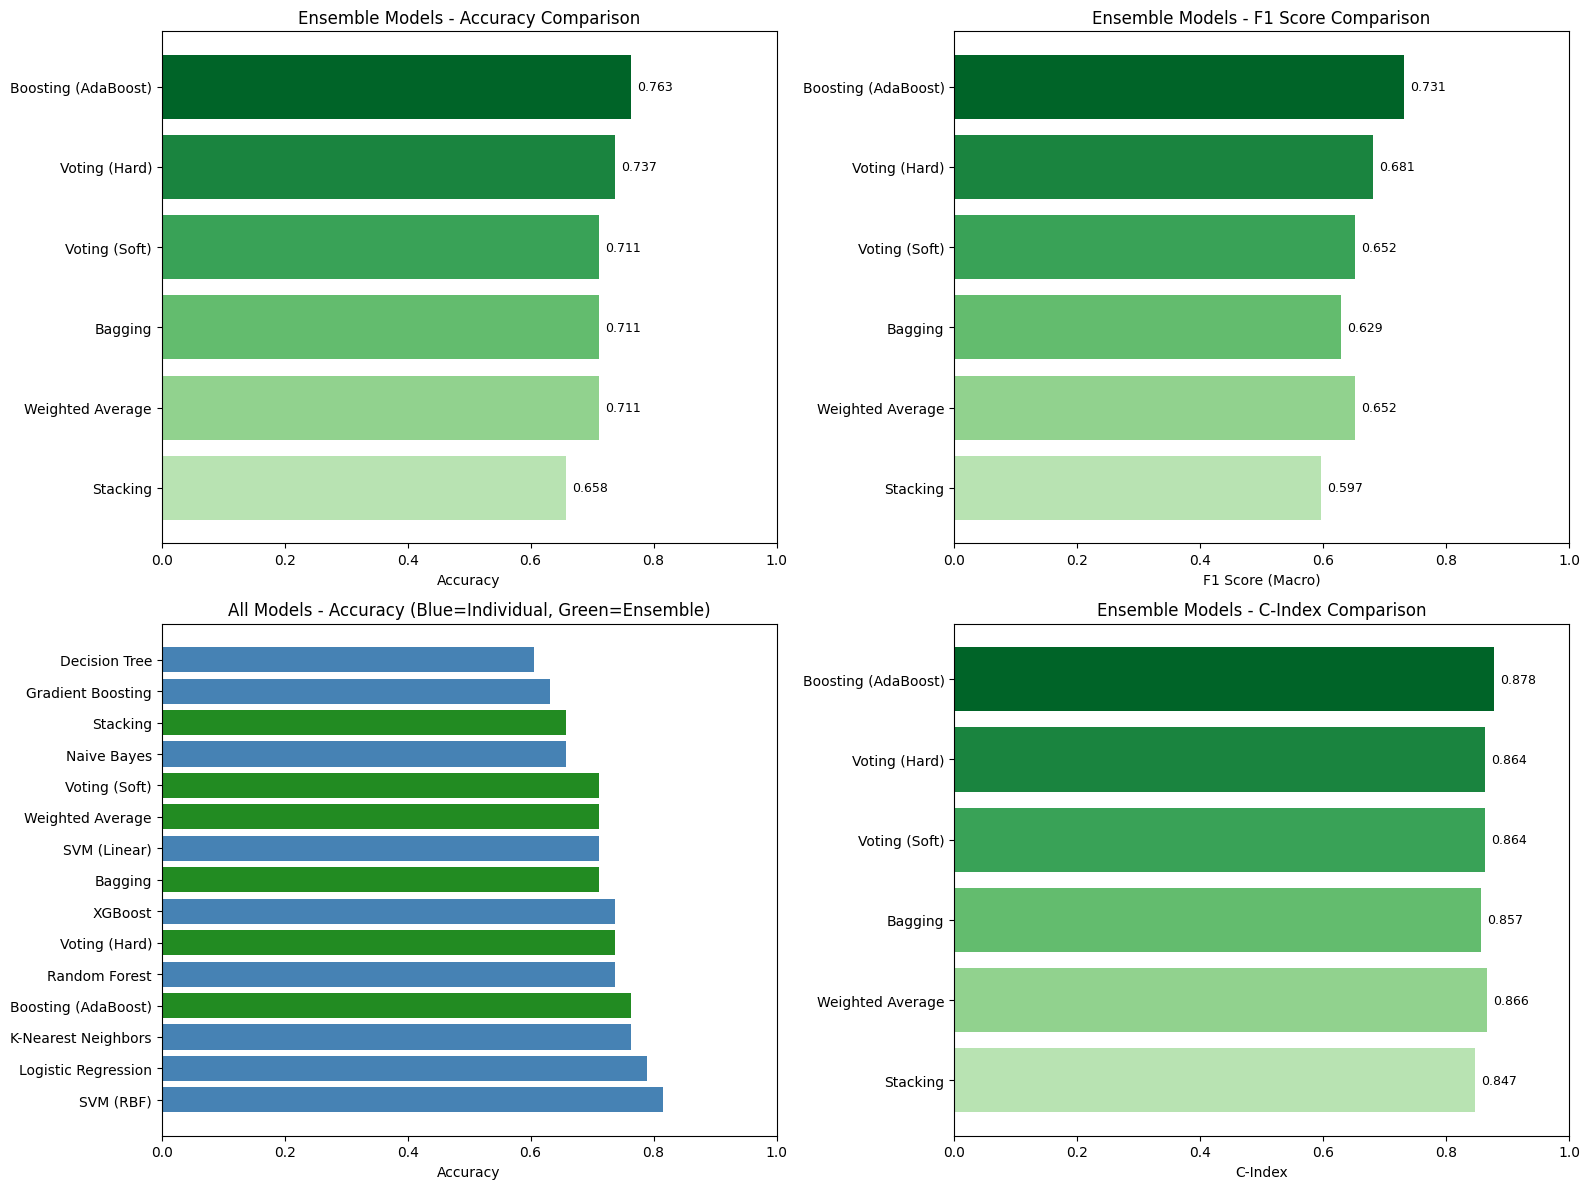


🏆 SUMMARY

📌 Best Ensemble Model: Boosting (AdaBoost)
   - Accuracy: 0.7632
   - F1 (Macro): 0.7315
   - C-Index: 0.8785

📌 Best Individual Model: SVM (RBF)
   - Accuracy: 0.8158
   - F1 (Macro): 0.7883
   - C-Index: 0.8802

🥇 Best Overall Model: SVM (RBF) (Individual)
   - Accuracy: 0.8158
   - F1 (Macro): 0.7883
   - C-Index: 0.8802


In [55]:
# ====================================================================
# ENSEMBLE MODELS - RESULTS & COMPARISON
# ====================================================================
import matplotlib.pyplot as plt

print("="*80)
print("ENSEMBLE MODELS EVALUATION RESULTS")
print("="*80)

# Evaluate all ensembles
ensemble_results = evaluate_multiple_ensembles(ensembles, X_test, y_test)

# Display results table
print("\n📊 ENSEMBLE PERFORMANCE COMPARISON:")
print("-"*80)
print(ensemble_results.to_string(index=False))

# Compare with best individual models
print("\n" + "="*80)
print("ENSEMBLE vs INDIVIDUAL MODELS COMPARISON")
print("="*80)

# Combine individual model results with ensemble results
individual_results = ml_results_df.copy()
individual_results = individual_results.rename(columns={
    'F1 Macro': 'F1 (Macro)', 
    'F1 Micro': 'F1 (Micro)',
    'Precision Macro': 'Precision (Macro)',
    'Precision Micro': 'Precision (Micro)',
    'Recall Macro': 'Recall (Macro)',
    'Recall Micro': 'Recall (Micro)'
})

# Add model type column
individual_results['Type'] = 'Individual'
ensemble_results_copy = ensemble_results.copy()
ensemble_results_copy['Type'] = 'Ensemble'

# Combine all results
all_results = pd.concat([individual_results, ensemble_results_copy], ignore_index=True)
all_results = all_results.sort_values('Accuracy', ascending=False)

print("\n📈 ALL MODELS RANKED BY ACCURACY:")
print("-"*80)
print(all_results[['Model', 'Type', 'Accuracy', 'F1 (Macro)', 'C-Index']].to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy comparison - Ensembles only
ensemble_sorted = ensemble_results.sort_values('Accuracy', ascending=True)
colors_ensemble = plt.cm.Greens(np.linspace(0.3, 0.9, len(ensemble_sorted)))
axes[0, 0].barh(ensemble_sorted['Model'], ensemble_sorted['Accuracy'], color=colors_ensemble)
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Ensemble Models - Accuracy Comparison')
axes[0, 0].set_xlim([0, 1])
for i, (acc, model) in enumerate(zip(ensemble_sorted['Accuracy'], ensemble_sorted['Model'])):
    axes[0, 0].text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=9)

# Plot 2: F1 Score comparison - Ensembles only
axes[0, 1].barh(ensemble_sorted['Model'], ensemble_sorted['F1 (Macro)'], color=colors_ensemble)
axes[0, 1].set_xlabel('F1 Score (Macro)')
axes[0, 1].set_title('Ensemble Models - F1 Score Comparison')
axes[0, 1].set_xlim([0, 1])
for i, (f1, model) in enumerate(zip(ensemble_sorted['F1 (Macro)'], ensemble_sorted['Model'])):
    axes[0, 1].text(f1 + 0.01, i, f'{f1:.3f}', va='center', fontsize=9)

# Plot 3: All models comparison (Individual vs Ensemble)
colors_all = ['steelblue' if t == 'Individual' else 'forestgreen' for t in all_results['Type']]
axes[1, 0].barh(all_results['Model'], all_results['Accuracy'], color=colors_all)
axes[1, 0].set_xlabel('Accuracy')
axes[1, 0].set_title('All Models - Accuracy (Blue=Individual, Green=Ensemble)')
axes[1, 0].set_xlim([0, 1])

# Plot 4: C-Index comparison
axes[1, 1].barh(ensemble_sorted['Model'], ensemble_sorted['C-Index'], color=colors_ensemble)
axes[1, 1].set_xlabel('C-Index')
axes[1, 1].set_title('Ensemble Models - C-Index Comparison')
axes[1, 1].set_xlim([0, 1])
for i, (ci, model) in enumerate(zip(ensemble_sorted['C-Index'], ensemble_sorted['Model'])):
    axes[1, 1].text(ci + 0.01, i, f'{ci:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("🏆 SUMMARY")
print("="*80)
best_ensemble = ensemble_results.loc[ensemble_results['Accuracy'].idxmax()]
best_individual = individual_results.loc[individual_results['Accuracy'].idxmax()]
best_overall = all_results.iloc[0]

print(f"\n📌 Best Ensemble Model: {best_ensemble['Model']}")
print(f"   - Accuracy: {best_ensemble['Accuracy']:.4f}")
print(f"   - F1 (Macro): {best_ensemble['F1 (Macro)']:.4f}")
print(f"   - C-Index: {best_ensemble['C-Index']:.4f}")

print(f"\n📌 Best Individual Model: {best_individual['Model']}")
print(f"   - Accuracy: {best_individual['Accuracy']:.4f}")
print(f"   - F1 (Macro): {best_individual['F1 (Macro)']:.4f}")
print(f"   - C-Index: {best_individual['C-Index']:.4f}")

print(f"\n🥇 Best Overall Model: {best_overall['Model']} ({best_overall['Type']})")
print(f"   - Accuracy: {best_overall['Accuracy']:.4f}")
print(f"   - F1 (Macro): {best_overall['F1 (Macro)']:.4f}")
print(f"   - C-Index: {best_overall['C-Index']:.4f}")